In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
!pip install -U "numpy<2.0" "scipy<1.14" "opencv-python-headless<4.10" albumentations segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopam

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
from pathlib import Path
import pandas as pd
import os

DATA_ROOT = Path("/kaggle/input/breast-cancer-semantic-segmentation-bcss/BCSS")
assert DATA_ROOT.exists(), "Dataset path is incorrect."
print("Dataset root:", DATA_ROOT)


Dataset root: /kaggle/input/breast-cancer-semantic-segmentation-bcss/BCSS


In [5]:
train_img_dir = DATA_ROOT / "train"
train_mask_dir = DATA_ROOT / "train_mask"

val_img_dir = DATA_ROOT / "val"
val_mask_dir = DATA_ROOT / "val_mask"


test_img_dir = Path("/kaggle/input/breast-cancer-semantic-segmentation-bcss/BCSS") / "test"  

print("Train images:", len(list(train_img_dir.iterdir())))
print("Train masks :", len(list(train_mask_dir.iterdir())))
print("Val images  :", len(list(val_img_dir.iterdir())))
print("Val masks   :", len(list(val_mask_dir.iterdir())))
print("Test images :", len(list(test_img_dir.iterdir())))

Train images: 30760
Train masks : 30760
Val images  : 5429
Val masks   : 5429
Test images : 4021


In [6]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

def list_images(folder: Path):
    return sorted([p for p in folder.iterdir() if p.suffix.lower() in IMG_EXTS])

def build_split_df(img_dir: Path, mask_dir: Path, split_name: str):
    images = list_images(img_dir)
    masks = list_images(mask_dir) if mask_dir else []

    # Build dictionary mask_stem -> file
    masks_by_stem = {m.stem: m for m in masks}

    rows = []
    for img in images:
        mask = masks_by_stem.get(img.stem, None)
        rows.append({
            "image_id": img.stem,
            "image_path": str(img),
            "mask_path": str(mask) if mask else None,
            "split": split_name
        })

    return pd.DataFrame(rows)

In [7]:
df_train = build_split_df(train_img_dir, train_mask_dir, "train")
df_val   = build_split_df(val_img_dir, val_mask_dir, "val")
df_test  = build_split_df(test_img_dir, None, "test")

df = pd.concat([df_train, df_val, df_test], ignore_index=True)

print("DataFrame shape:", df.shape)
df.head()


DataFrame shape: (40210, 4)


,image_id,image_path,mask_path,split
0,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_1...,/kaggle/input/breast-cancer-semantic-segmentat...,/kaggle/input/breast-cancer-semantic-segmentat...,train
1,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_1...,/kaggle/input/breast-cancer-semantic-segmentat...,/kaggle/input/breast-cancer-semantic-segmentat...,train
2,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_1...,/kaggle/input/breast-cancer-semantic-segmentat...,/kaggle/input/breast-cancer-semantic-segmentat...,train
3,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_1...,/kaggle/input/breast-cancer-semantic-segmentat...,/kaggle/input/breast-cancer-semantic-segmentat...,train
4,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_0_2...,/kaggle/input/breast-cancer-semantic-segmentat...,/kaggle/input/breast-cancer-semantic-segmentat...,train


In [8]:
#Save as CSV for later use.
OUT_PATH = "/kaggle/working/bcss_index.csv"
df.to_csv(OUT_PATH, index=False)

print("Saved to:", OUT_PATH)
print(df["split"].value_counts())

Saved to: /kaggle/working/bcss_index.csv
split
train    30760
val       5429
test      4021
Name: count, dtype: int64


In [9]:
# Visualize the images (Just random 10 images)
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_image_with_mask(image_path, mask_path=None):
    img = np.array(Image.open(image_path))

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")

    if mask_path:
        mask = np.array(Image.open(mask_path))

        # Normalize mask for visualization
        if mask.ndim == 3:  
            # if mask is RGB, convert to grayscale
            mask = mask[..., 0]

        # Create overlay with transparency
        plt.imshow(mask, cmap="jet", alpha=0.5)

    plt.show()


# Select random samples that have masks
df_with_mask = df[df["mask_path"].notna()]
n_samples = min(10, len(df_with_mask))

sample_rows = df_with_mask.sample(n_samples, random_state=42)

print("Read data successfully")

Read data successfully


In [10]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

In [11]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 4
NUM_EPOCHS = 60
LR = 1e-3

NUM_CLASSES = 3
# MAX_TRAIN_SAMPLES = 10000

n_gpus = torch.cuda.device_count()
DEVICE = "cuda" if n_gpus > 0 else "cpu"
print("Number of GPUs:", n_gpus)
print("Using DEVICE:", DEVICE)

Number of GPUs: 1
Using DEVICE: cuda


In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd

# I would like to combine the data in each group.
MAPPING_DICT = {
    0: 0,   
    7: 0,  
    15: 0,
    21: 0,

    1: 1,   
    19: 1,  
    20: 1, 

    2: 2,   
    16: 2,  
    17: 2, 
    18: 2, 

    3: 3,   
    10: 3,  
    11: 3,  

    4: 4,   

    5: 5,  
    6: 5,  
    8: 5,  
    9: 5,  
    12: 5,  
    13: 5,  
    14: 5 
}

def create_mapping_array(mapping_dict, max_val=21):
    map_arr = np.full(max_val + 1, 5, dtype=np.uint8)
    for k, v in mapping_dict.items():
        if k <= max_val:
            map_arr[k] = v
    return map_arr

MAP_ARRAY = create_mapping_array(MAPPING_DICT)

class BCSSSegDataset(Dataset):
    def __init__(self, df, img_size=(224, 224), augment=False):
        self.df = df.reset_index(drop=True)
        self.augment = augment

        if augment:
            self.transform = A.Compose([
                A.Resize(height=img_size[0], width=img_size[1]),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
                
                A.OneOf([
                    A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
                ], p=0.3),
                
                A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.3),
                
                A.OneOf([
                    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1),
                    A.GaussianBlur(blur_limit=(3, 5), p=1),
                    A.GaussNoise(var_limit=(10.0, 50.0), p=1),
                ], p=0.4),
                
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=img_size[0], width=img_size[1]),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        mask_path = row["mask_path"]

        image = np.array(Image.open(img_path).convert("RGB"))
        
        if pd.isna(mask_path):
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
        else:
            mask = np.array(Image.open(mask_path), dtype=np.uint8)
            
            mask[mask > 2] = 0 

        transformed = self.transform(image=image, mask=mask)
        return transformed["image"], transformed["mask"].long()

In [13]:
from torch.utils.data import DataLoader
import os

NW = min(8, os.cpu_count() or 4)

df_train = df[df["split"] == "train"].copy()
df_val   = df[df["split"] == "val"].copy()
df_test  = df[df["split"] == "test"].copy()

train_dataset = BCSSSegDataset(df_train, img_size=IMG_SIZE, augment=True)
val_dataset   = BCSSSegDataset(df_val,   img_size=IMG_SIZE, augment=False)
test_dataset  = BCSSSegDataset(df_test,  img_size=IMG_SIZE, augment=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NW,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NW,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 30760, Val: 5429, Test: 4021


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/2037078514.py:65: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
/tmp/ipykernel_19/2037078514.py:68: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_holes=2, p=0.3),
/tmp/ipykernel_19/2037078514.py:73: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1),


In [14]:
import torch
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    decoder_attention_type=None,   # bỏ scse để nhanh hơn
)

model.segmentation_head = nn.Sequential(
    nn.Dropout2d(p=0.5),            # Thêm Dropout 50%
    model.segmentation_head         # Giữ nguyên lớp head cũ
)

model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [15]:
import torch

torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")  # pytorch >= 2.0
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [16]:
optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 6e-5},
    {'params': model.decoder.parameters(), 'lr': 6e-4}, 
    {'params': model.segmentation_head.parameters(), 'lr': 6e-4},
], weight_decay=0.05) 

import torch.nn as nn
import segmentation_models_pytorch as smp
class_weights = torch.tensor([1.06, 0.87, 1.1], device=DEVICE)

ce   = nn.CrossEntropyLoss(weight=class_weights)
dice = smp.losses.DiceLoss(mode="multiclass", from_logits=True)

def criterion(preds, targets):
    targets = targets.long()
    return 0.6 * ce(preds, targets) + 0.4 * dice(preds, targets)


In [17]:
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast, GradScaler

In [18]:
import torch
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler(enabled=torch.cuda.is_available())

def train_one_epoch(model, loader, optimizer, criterion, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0
    
    optimizer.zero_grad(set_to_none=True) # Reset grad ở ngoài vòng lặp hoặc đầu epoch

    for i, (imgs, masks) in enumerate(loader):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            outputs = model(imgs)
            loss = criterion(outputs, masks.long())
            loss = loss / accumulation_steps # Chia nhỏ loss

        scaler.scale(loss).backward()

        # Chỉ cập nhật weights sau mỗi accumulation_steps
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        # Log lại loss gốc (nhân lại để hiển thị đúng)
        running_loss += (loss.item() * accumulation_steps) * imgs.size(0)

        with torch.no_grad():
            preds = outputs.argmax(dim=1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

    avg_loss = running_loss / max(len(loader.dataset), 1)
    accuracy = correct_pixels / max(total_pixels, 1)
    return avg_loss, accuracy

/tmp/ipykernel_19/242176594.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [19]:
@torch.no_grad()
def evaluate(model, loader, criterion, device, num_classes=3):
    model.eval()
    running_loss = 0.0

    # confusion matrix: rows = target, cols = pred
    conf = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=device)

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        with autocast(enabled=torch.cuda.is_available()):
            outputs = model(imgs)
            loss = criterion(outputs, masks.long())

        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)

        # flatten
        t = masks.view(-1).long()
        p = preds.view(-1).long()

        # clamp safety (nếu mask/pred lỡ có giá trị ngoài [0..C-1])
        valid = (t >= 0) & (t < num_classes) & (p >= 0) & (p < num_classes)
        t = t[valid]
        p = p[valid]

        conf += torch.bincount(t * num_classes + p, minlength=num_classes**2).view(num_classes, num_classes)

    avg_loss = running_loss / max(len(loader.dataset), 1)

    tp = conf.diag().float()
    fp = conf.sum(0).float() - tp
    fn = conf.sum(1).float() - tp

    iou_per_class = (tp + 1e-6) / (tp + fp + fn + 1e-6)
    f1_per_class  = (2 * tp + 1e-6) / (2 * tp + fp + fn + 1e-6)

    mean_iou = iou_per_class.mean().item()
    mean_f1  = f1_per_class.mean().item()

    print(f"\nClass IoUs: {iou_per_class.detach().cpu().numpy()}")

    return avg_loss, mean_f1, mean_iou


In [20]:
import os
BEST_MODEL_PATH = "/kaggle/working/unet_bcss_best.pth"
CKPT_PATH = "/kaggle/working/unet_checkpoint.pth" 
start_epoch = 1
best_val_loss = float("inf")

In [21]:
import time
import datetime
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",        # vì theo val_loss
    factor=0.5,
    patience=2,
    threshold=1e-3,
    cooldown=1,
    min_lr=1e-7,
    verbose=True,
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
history = {
    "train_loss": [],
    "train_acc": [], 
    "val_loss": [],
    "val_f1": [], 
    "val_iou": []
}

print(f"Start Training")
total_t0 = time.time()
best_val_f1 = 0.0
epochs_no_improve = 0
early_stop_patience = 10


# Start training loop
for epoch in range(start_epoch, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    
    val_loss, val_f1, val_iou = evaluate(model, val_loader, criterion, DEVICE, NUM_CLASSES)
    scheduler.step(val_loss)
    
    epoch_elapsed = time.time() - epoch_start_time
    
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_f1"].append(val_f1)
    history["val_iou"].append(val_iou)

    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        epochs_no_improve += 1
        

    print(f"[Epoch {epoch}/{NUM_EPOCHS}] | Time: {format_time(epoch_elapsed)} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val IoU: {val_iou:.4f}")

    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_val_loss": best_val_loss,
        "history": history
    }
    torch.save(ckpt, CKPT_PATH)

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}")
        break
print(f"\nTotal time of training: {format_time(time.time() - total_t0)}")

Start Training


/tmp/ipykernel_19/2848604361.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):



Class IoUs: [0.44234997 0.7028652  0.5435374 ]
[Epoch 1/60] | Time: 0:09:13 | Train Loss: 0.7123 | Val Loss: 0.5972 | Val F1: 0.7144 | Val IoU: 0.5629

Class IoUs: [0.47892877 0.72193867 0.55467355]
[Epoch 2/60] | Time: 0:09:00 | Train Loss: 0.6446 | Val Loss: 0.5696 | Val F1: 0.7332 | Val IoU: 0.5852

Class IoUs: [0.48273546 0.72378653 0.55159944]
[Epoch 3/60] | Time: 0:09:01 | Train Loss: 0.6117 | Val Loss: 0.5690 | Val F1: 0.7340 | Val IoU: 0.5860

Class IoUs: [0.48346162 0.7274023  0.56116307]
[Epoch 4/60] | Time: 0:08:55 | Train Loss: 0.5990 | Val Loss: 0.5561 | Val F1: 0.7376 | Val IoU: 0.5907

Class IoUs: [0.44970056 0.72707    0.5607233 ]
[Epoch 5/60] | Time: 0:08:53 | Train Loss: 0.5866 | Val Loss: 0.5716 | Val F1: 0.7270 | Val IoU: 0.5792

Class IoUs: [0.48524994 0.7298332  0.5597374 ]
[Epoch 6/60] | Time: 0:08:52 | Train Loss: 0.5791 | Val Loss: 0.5644 | Val F1: 0.7383 | Val IoU: 0.5916

Class IoUs: [0.42330977 0.7386753  0.5591989 ]
[Epoch 7/60] | Time: 0:08:51 | Train Los

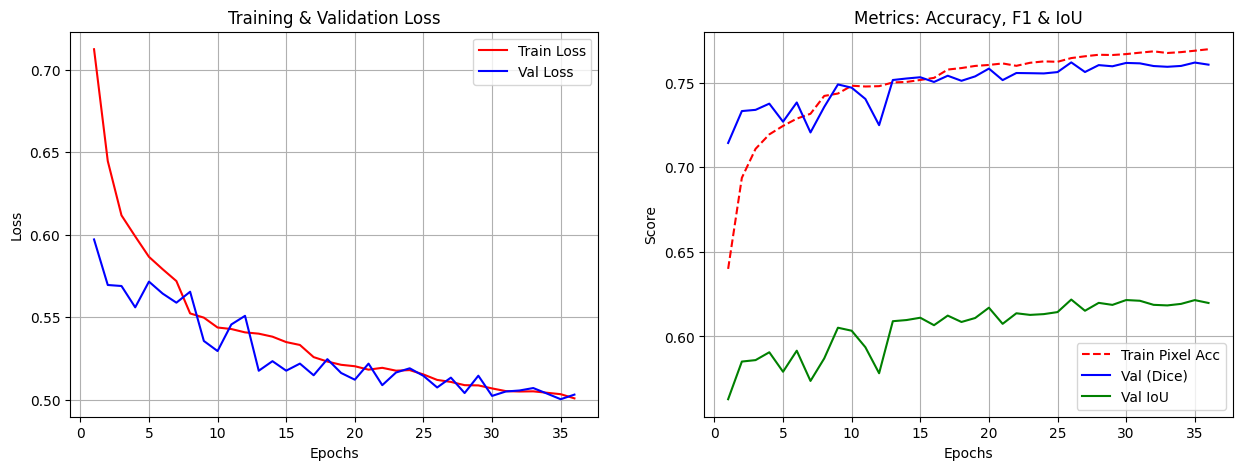

In [24]:
import matplotlib.pyplot as plt

if len(history["train_loss"]) > 0:
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'r-', label="Train Loss")
    plt.plot(epochs, history["val_loss"], 'b-', label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], 'r--', label="Train Pixel Acc") 
    
    plt.plot(epochs, history["val_f1"], 'b-', label="Val (Dice)") 
    
    plt.plot(epochs, history["val_iou"], 'g-', label="Val IoU")
    
    plt.title("Metrics: Accuracy, F1 & IoU")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    plt.show()
else:
    print("There no data in history.")